In [1]:
##########
# These are the essential libraries and model functions

import numpy as np
import pylab as pl
from numba import jit
import random
from matplotlib import colors

dt = 0.01   # Forward euler numerical simulation time step


@jit  # We use python-numba to speed up the simulation
def simulate_integration(is_embedded_fish, ts, Is, xs, bout_times, bout_decisions):
    """
    :param is_embedded_fish: embedded fish? This sets clock to zero.
    :param ts: vector of times (will be filled)
    :param Is: vector of coherences over time (will be read out)
    :param xs: vector of integrator states (will be filled)
    :param bout_times: vector of the times the fish bouts (will be filled)
    :param bout_decisions: vector of turning decisions per bout (will be filled)
    :return: number of found bouts
    """
    
    # We have only three model parameters
    tau = 2  # Time constant of the leaky integrator
    T = 0.15  # Upper and lower threshold
    c = 0.0011  # Conversion factor the coherence level
    
    # in case of embedded fish, turn off the bout clock
    if is_embedded_fish:
        bout_clock_probability = 0
    else:
        bout_clock_probability = 0.012
    
    noise_sigma = 1  # not a parameter (can be compensated by scaling tau, T, and c)

    xs[0] = 0
    ts[0] = 0
    bout_times[0] = 0 
    bout_counter = 0
    
    for i in range(1, len(ts)):
        
        # In the case of the embedded fish, turn off stimulus after first bout
        if is_embedded_fish and bout_counter > 0:
            Is[i] = 0
            
        dx = c * Is[i] + random.gauss(0, noise_sigma) - xs[i-1]
        
        xs[i] = xs[i-1] + dx * dt / tau
        ts[i] = ts[i-1] + dt
        
        if bout_counter == 0:
            time_since_last_bout = 99  # no refractory period for the first bout
        else:
            time_since_last_bout = ts[i] - bout_times[bout_counter-1]
            
        if (time_since_last_bout > 0.5):  # refractory period 500 ms
            if (xs[i] > T or xs[i] < -T or random.random() < bout_clock_probability):
                
                bout_times[bout_counter] = ts[i]
                bout_decisions[bout_counter] = -1 if xs[i] < 0 else 1
    
                bout_counter += 1

    return bout_counter

In [2]:
##########
# Reproduction of simulation data from Figure 1.

swims_per_second = []
fraction_of_correct_bouts = []
fraction_of_correct_bouts_over_time = []

bout_times = np.empty(10000)
bout_decisions = np.empty(10000)

ts = np.arange(0, 30, dt)
xs = np.empty_like(ts)

for coherence in [0, 25, 50, 100]:
    
    swims_per_second_per_coherence = []
    
    correct_swims = 0
    total_swims = 0
    
    correct_swims_over_time = np.zeros(15) # 30 s has 15 2s time bins
    total_swims_over_time = np.zeros(15)
    
    for trial in range(2000):
        
        Is = np.zeros_like(ts)
        Is[((ts > 10) & (ts < 20))] = coherence
    
        bout_counter = simulate_integration(
            False, ts, Is, xs, bout_times, bout_decisions)
        
        bout_times_trial = bout_times[:bout_counter]
        bout_decisions_trial = bout_decisions[:bout_counter]
        
        
        ind_stimulus = np.where((bout_times_trial > 10) &
                                (bout_times_trial < 20))
            
        swims_per_second_per_coherence.append(
            len(bout_times_trial[ind_stimulus]) / 10.)
        
        for bout_time, bout_decision in zip(bout_times_trial, bout_decisions_trial):
            
            total_swims_over_time[int(bout_time / 2)] += 1
            
            if bout_decision == 1:
                correct_swims_over_time[int(bout_time / 2)] += 1
                
        correct_swims += (bout_decisions_trial[ind_stimulus] == 1).sum()
        total_swims += len(bout_decisions_trial[ind_stimulus])
    
    swims_per_second.append(np.mean(swims_per_second_per_coherence))
    
    fraction_of_correct_bouts.append(100 * correct_swims / total_swims)
    
    fraction_of_correct_bouts_over_time.append(
        100 * np.array(correct_swims_over_time) / np.array(total_swims_over_time))

fraction_of_correct_bouts_over_time = np.array(fraction_of_correct_bouts_over_time)

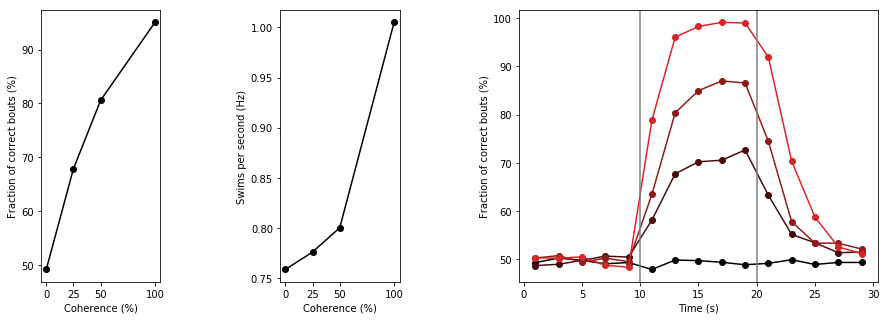

In [3]:
##########
# Plot the behavior, this should reproduce Figure 1h-j

pl.figure(figsize=(15,5))
grid = pl.GridSpec(1, 4, wspace=1, hspace=0.3)

# How does average accuracy on coherence?
pl.subplot(grid[0, 0])
pl.plot([0, 25, 50, 100], fraction_of_correct_bouts, '-o', color='k')
pl.xticks([0, 25, 50, 100])
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Fraction of correct bouts (%)")

# How does swims per second depend on coherence?
pl.subplot(grid[0, 1])
pl.plot([0, 25, 50, 100], swims_per_second, '-o', color='k')
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Swims per second (Hz)")

# The accuracy evolution over time
pl.subplot(grid[0, 2:])
hsv_color = colors.rgb_to_hsv(colors.to_rgb("C3"))
for stim in range(4):
    
    color_saturated = colors.hsv_to_rgb([hsv_color[0], 
                                         hsv_color[1] , 
                                         hsv_color[2] * stim / 3])
        
    pl.plot(np.arange(0, 30, 2) + 1, 
            fraction_of_correct_bouts_over_time[stim], '-o', 
            color = color_saturated)
    
pl.axvline(10, color='gray')
pl.axvline(20, color='gray')
pl.xlabel("Time (s)")
pl.ylabel("Fraction of correct bouts (%)")

pl.show()

In [4]:
##########
# Reproduction of simulation data from Figure 2.

fraction_of_trials_with_a_bout = []
response_delays = []
fraction_of_correct_bouts = []

bout_times = np.empty(10000)
bout_decisions = np.empty(10000)

ts = np.arange(0, 45, dt)
xs = np.empty_like(ts)

for coherence in [0, 25, 50, 100]:
    
    trials_with_a_bout = 0
    total_started_trials = 0
    trials_with_a_correct_bout = 0
    
    response_delays_per_coherence = []
    
    for trial in range(5000):
        
        Is = np.zeros_like(ts)
        Is[ts > 5] = coherence
    
        bout_counter = simulate_integration(
            True, ts, Is, xs, bout_times, bout_decisions)
            
        bout_times_trial = bout_times[:bout_counter]
        bout_decisions_trial = bout_decisions[:bout_counter]
        
        # If a bout occurs too early, discard that trial
        if (bout_times_trial < 5).any():  
            continue
        
        total_started_trials += 1
        
        if bout_counter > 0:
            trials_with_a_bout += 1
            
            response_delays_per_coherence.append(bout_times_trial[0] - 5)
            
            if bout_decisions_trial[0] == 1:
                trials_with_a_correct_bout += 1
       
    fraction_of_trials_with_a_bout.append(
        100 * trials_with_a_bout / total_started_trials)
    
    response_delays.append(np.mean(response_delays_per_coherence))
    
    fraction_of_correct_bouts.append(
        100 * trials_with_a_correct_bout / trials_with_a_bout)

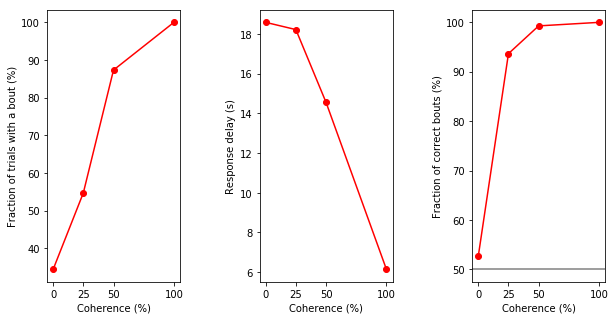

In [5]:
##########
# Do the plotting (this should reproduce Figure 2c)

pl.figure(figsize=(10,5))
grid = pl.GridSpec(1, 3, wspace=0.6, hspace=0.3)
pl.subplot(grid[0, 0])
pl.plot([0, 25, 50, 100], fraction_of_trials_with_a_bout, '-o', color='r')
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Fraction of trials with a bout (%)")

pl.subplot(grid[0, 1])
pl.plot([0, 25, 50, 100], response_delays, '-o', color='r')
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Response delay (s)")

pl.subplot(grid[0, 2])
pl.plot([0, 25, 50, 100], fraction_of_correct_bouts, '-o', color='r')
pl.xlabel("Coherence (%)")
pl.xticks([0, 25, 50, 100])
pl.ylabel("Fraction of correct bouts (%)")
pl.axhline(50, color='gray')

pl.show()